In [58]:
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

In [59]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import sys
import importlib
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [60]:
OPENAI_API_KEY = ""
OPENAI_MODEL = "o4-mini" # "gpt-4o" "o4-mini" #gpt-3.5-turbo"

In [61]:
model = ChatOpenAI(api_key=OPENAI_API_KEY,model=OPENAI_MODEL)

In [62]:
checkpointer = InMemorySaver()
store = InMemoryStore()

In [69]:
df = pd.read_csv('./file/cars_data.csv')
df.head(5)

,id,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,2548,dohc,4,130,mpfi,111.0,5000.0,21,27,13495.0
1,1,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,2548,dohc,4,130,mpfi,111.0,5000.0,21,27,16500.0
2,2,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,2823,ohcv,6,152,mpfi,154.0,5000.0,19,26,16500.0
3,3,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,2337,ohc,4,109,mpfi,102.0,5500.0,24,30,13950.0
4,4,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,2824,ohc,5,136,mpfi,115.0,5500.0,18,22,17450.0


<img src="./images/ma_super_clusterig.png" alt="Description">

In [63]:
# Create tools, which will be later used by specialized agent
##Defining the clustering tool
def clustering(col:list, k:int,input_datafile:str) -> str:
    """Perform clustering on specified columns of a DataFrame. 
        The clustering are stored in an output file, whose name is returned from the tool

        Args:
            cols: List of column names to use for clustering
            k: Number of clusters to create
            input_datafile: Name of file to get input data
            
    """
    try:
        print ('col..',col)
        print ('input_datafile..',input_datafile)
        ##Reading data
        df = pd.read_csv(input_datafile)
        df_cluster = df.copy()
        df = df[col]

        #Getting numeroc and categorical columns
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    
        # Preprocessing pipeline
        transformers = []

        #If there are numeric columns, then add Standard scaler to Preprocessing pipeline
        if numeric_cols:
            transformers.append(("num", StandardScaler(), numeric_cols))

        #If there are categorical columns, then add to Onehot encoding to Preprocessing pipeline
        if categorical_cols:
            transformers.append(("cat", OneHotEncoder(), categorical_cols))
            
        #Create column transformer 
        if transformers:
            preprocessor = ColumnTransformer(transformers)
           
        else:
            preprocessor = None
           
    
    
        # Apply preprocessing
        try:
            X = preprocessor.fit_transform(df).toarray() 
            
        except:
            X = preprocessor.fit_transform(df)
           
        
        # KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
    
        # PCA for dimensionality reduction
        pca = PCA(n_components=2)
        pca_components = pca.fit_transform(X)
    
      
        #Create columns for which have the two dimensions of PCA
        df_cluster['PCA_1'] = pca_components[:, 0]
        df_cluster['PCA_2'] = pca_components[:, 1]
        
        #Create column for Cluster
        df_cluster['Cluster'] = ["Cluster "+str(c) for c in clusters]

        #Store resulting dataframe into file_out
        file_out = './output/clustering_tool.csv'
        df_cluster.to_csv(file_out,index=False)
        df_cluster.head(5)

        #Create a response that clustering is done. And results are stores in file_out. 
        response = 'Clustering has been calculated. The results are stored in '+file_out+'
        
    except Exception as e:
        print ('Clustering error..'+str(e))
        response = "Unfortuanately some error occured while clustering."    
    
    return response


    





<img src="./images/ma_super_visualization.png" alt="Description">

In [ ]:
##Defining the visualization tool
def visualize(input_datafile:str) -> str:
    """Visualize data
    The visualization are stored in an output file, whose name is returned from the tool
    
    Args:
        input_datafile: Name of file to get input data
    """
    print ('For Visualization, input_datafile is ',input_datafile)
    try:
        print ('input_datafile..',input_datafile)
        if input_datafile == './output/clustering_tool.csv':
            # Assuming your dataframe is called 'df'
            df = pd.read_csv(input_datafile)
            print ('df...',df.head(5))
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=df, x='PCA_1', y='PCA_2', hue='Cluster', palette='viridis')
    
            plt.title('PCA Scatter Plot by Cluster')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend(title='Cluster')
            plt.show()
        
    
        response = 'Visualization done'
    except Exception as e:
        print ('Visualizing error..'+str(e))
        response = "Unfortuanately some error occured while visualizing."    
    
    return response

In [ ]:
##Defining the agents
clustering_agent = create_react_agent(
    model=model,
    tools=[clustering],
    name="clustering_expert",
    prompt="You are clustering expert. Always use one tool at a time."
)

visualization_agent = create_react_agent(
    model=model,
    tools=[visualize],
    name="visualization_expert",
    prompt="You are visualization expert. Always use one tool at a time."
)


# Create supervisor workflow
workflow = create_supervisor(
    [clustering_agent,visualization_agent],
    model=model,
    output_mode="full_history",
    prompt=(
        "You are a team supervisor managing a clustering expert and a visualization expert.  "
        "For clustering, use clustering_agent. "
        "For visualization, use visualization_agent."
        "Each agent will output a filename, which needs to be passed to next agent whichever is called"
    )
)

# Compile and run
app = workflow.compile(
    checkpointer=checkpointer,
    store=store
)

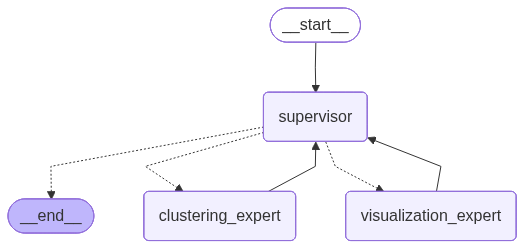

In [64]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [65]:
def invoke_app(app, query):
    result = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": query
            },
            
        ],
        
    },
                        config={"configurable": {"thread_id": "123"}}, 
                       )
    return result

In [66]:
query = "Give me clustering based on length, width, price. Make 3 clusters. Also Input file is ./file/cars_data.csv. Make visualization"

col.. ['length', 'width', 'price']
input_datafile.. ./file/cars_data.csv
For Visualization, input_datafile is  ./output/clustering_tool.csv
input_datafile.. ./output/clustering_tool.csv
df...    id         make fuel-type aspiration  num-of-doors   body-style  \
0   0  alfa-romero       gas        std             2  convertible   
1   1  alfa-romero       gas        std             2  convertible   
2   2  alfa-romero       gas        std             2    hatchback   
3   3         audi       gas        std             4        sedan   
4   4         audi       gas        std             4        sedan   

  drive-wheels engine-location  wheel-base  length  ...  engine-size  \
0          rwd           front        88.6   168.8  ...          130   
1          rwd           front        88.6   168.8  ...          130   
2          rwd           front        94.5   171.2  ...          152   
3          fwd           front        99.8   176.6  ...          109   
4          4wd           fr

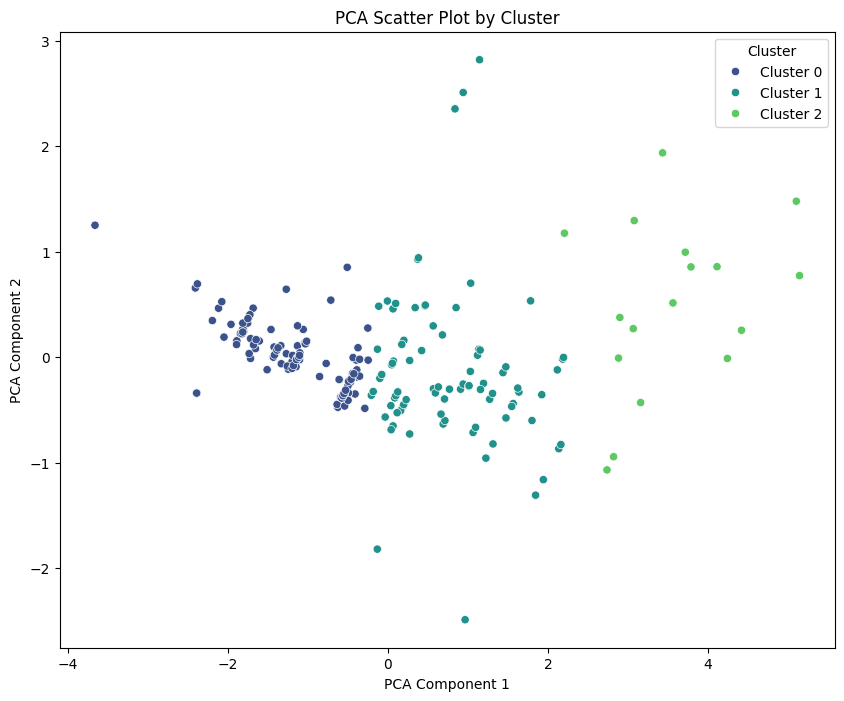

In [67]:
result = invoke_app(app, query)

In [68]:
for message in result['messages']:
    print (message.pretty_print())

================================ Human Message =================================

Give me clustering based on length, width, price. Make 3 clusters. Also Input file is ./file/cars_data.csv
None
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_clustering_expert (call_epvet0ze78xiJyAQTbOd99bW)
 Call ID: call_epvet0ze78xiJyAQTbOd99bW
  Args:
None
================================= Tool Message =================================
Name: transfer_to_clustering_expert

Successfully transferred to clustering_expert
None
================================== Ai Message ==================================
Name: clustering_expert
Tool Calls:
  clustering (call_35QBCQ0g7Xz46FQ0sklcs7AK)
 Call ID: call_35QBCQ0g7Xz46FQ0sklcs7AK
  Args:
    col: ['length', 'width', 'price']
    k: 3
    input_datafile: ./file/cars_data.csv
None
================================= Tool Message =================================
Name: clustering

Clusteri